# DeScoD-ECG (Li et al., 2023)

##### Modules

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Subset, ConcatDataset, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pickle
import yaml
from IPython.display import Image
from scipy.fft import fft, fftshift
from scipy.io import loadmat
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
folder_path = "/Users/eugeniebouniol/Documents/SAIL/ddpm-mrs/"
data_path = "/Users/eugeniebouniol/Documents/SAIL/ddpm-mrs/data/"

model_name = "2chans_100ep_spec"
model_path = "/Users/eugeniebouniol/Documents/SAIL/ddpm-mrs/check_points/" + model_name + "/final.pth"

sys.path.append(folder_path)
os.chdir(folder_path)

from main_model import DDPM
from denoising_model_small import ConditionalModel

In [3]:
from utils import evaluate

##### Model

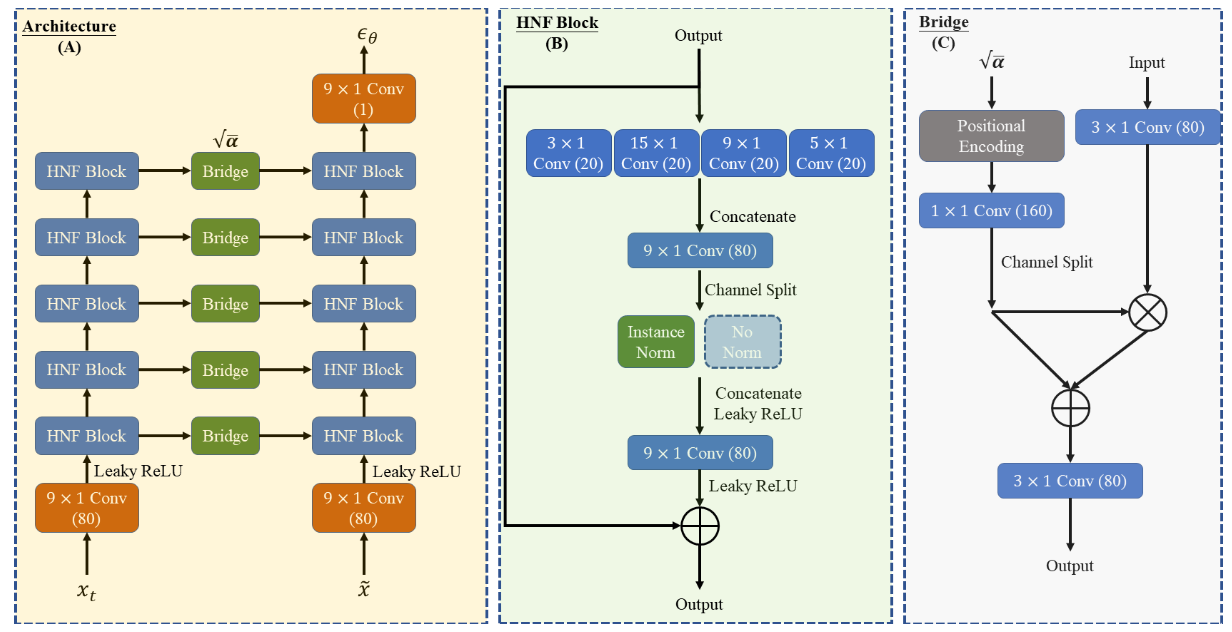

In [4]:
display(Image(filename='img.png'))

##### Training

##### Loading Model

In [5]:
#device = "cuda:0"
device = "cpu"
path = "./config/base.yaml"
with open(path, "r") as f:
    config = yaml.safe_load(f)

In [6]:
N_channels = 2
print("Initializing base model.. ")
base_model = ConditionalModel(config['train']['feats'], N_channels).to(device)
print("Initializing DDPM.. ")
model = DDPM(base_model, config, device)
print("Done.")

Initializing base model.. 
Initializing DDPM.. 
Done.


##### Data preparation (In Vivo Data)

##### Data Preparation (Kay)

##### Loading Data

In [25]:
from Data_Preparation.data_preparation_mrs import Data_Preparation

In [26]:
train_set, val_set, test_set = Data_Preparation(data_path)

Loading raw data...
GT shape:  (101, 100, 2048, 2)
Noisy shape:  (101, 100, 2048, 2)
Starting dataset generation...


100%|█████████████████████████████████████████| 101/101 [00:08<00:00, 11.90it/s]


Converting data to tensors...
Done.
Dataset ready.


##### Performance on test set

In [27]:
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [28]:
test_features, test_labels = next(iter(test_dataloader))
X_test = torch.FloatTensor(test_features).to(device) #.cpu().numpy()
y_test = torch.FloatTensor(test_labels).to(device) #.cpu().numpy()
# y_test_pred = model.denoising(X_test)#.permute(0,2,1))

In [29]:
X_test.shape

torch.Size([64, 2, 2048])

In [30]:
y_test.shape

torch.Size([64, 2, 2048])

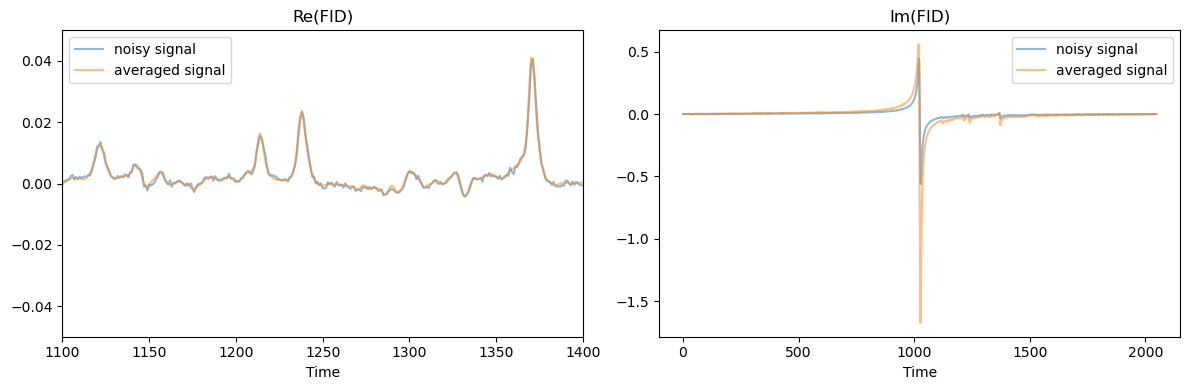

In [33]:
X_test_ar = X_test.cpu().numpy()
y_test_ar = y_test.cpu().numpy()
#y_test_pred_ar = y_test_pred.cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize = (12, 4) )
sample = 2

# estimating bias
#X = np.vstack((np.ones_like(y_test_ar[sample, 0]), y_test_ar[sample, 0]))
#theta_0 = np.linalg.pinv(X.T) @ y_test_pred_ar[sample, 0]

ax[0].plot( X_test_ar[sample, 0], label = "noisy signal", alpha = 0.5)
ax[0].plot( X_test_ar[sample, 0] - y_test_ar[sample, 0], label = "averaged signal" , alpha = 0.5)
#ax[0].plot( y_test_pred_ar[sample, 0] - theta_0[0], label = "denoised signal", alpha = 0.5)
ax[0].set_xlabel("Time")
ax[0].legend()
ax[0].set_title("Re(FID)")
ax[0].set_ylim([-0.05, 0.05])
ax[0].set_xlim([1100, 1400])

#X = np.vstack((np.ones_like(y_test_ar[sample, 1]), y_test_ar[sample, 1]))
#theta_1 = np.linalg.pinv(X.T) @ y_test_pred_ar[sample, 1]

ax[1].plot( X_test_ar[sample, 1], label = "noisy signal", alpha = 0.5)
ax[1].plot( X_test_ar[sample, 1] - y_test_ar[sample, 1], label = "averaged signal" , alpha = 0.5)
#ax[1].plot( y_test_pred_ar[sample, 1] - theta_1[0], label = "denoised signal", alpha = 0.5)
ax[1].set_xlabel("Time")
ax[1].legend()
ax[1].set_title("Im(FID)")

fig.tight_layout()

##### Performance on training set

In [ ]:
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
X_train = torch.FloatTensor(train_features).to(device) #.cpu().numpy()
y_train = torch.FloatTensor(train_labels).to(device) #.cpu().numpy()
y_train_pred = model.denoising(X_train)#[..., 0:1].permute(0,2,1))

In [ ]:
X_train.shape

In [ ]:
X_train_ar = X_train.cpu().numpy()
y_train_ar = y_train.cpu().numpy()
y_train_pred_ar = y_train_pred.cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize = (12, 4) )
sample = 0

# estimating bias
X = np.vstack((np.ones_like(y_train_ar[sample, 0]), y_train_ar[sample, 0]))
theta_0 = np.linalg.pinv(X.T) @ y_train_pred_ar[sample, 0]

ax[0].plot( X_train_ar[sample, 0], label = "noisy signal", alpha = 0.5)
ax[0].plot( y_train_ar[sample, 0], label = "averaged signal" , alpha = 0.5)
ax[0].plot( y_train_pred_ar[sample, 0] - theta_0[0], label = "denoised signal", alpha = 0.5)
ax[0].set_xlabel("Time")
ax[0].legend()
ax[0].set_title("Re(Spectrum)")
ax[0].set_ylim([-0.05, 0.05])
ax[0].set_xlim([1100, 1400])

X = np.vstack((np.ones_like(y_train_ar[sample, 1]), y_train_ar[sample, 1]))
theta_1 = np.linalg.pinv(X.T) @ y_train_pred_ar[sample, 1]

ax[1].plot( X_train_ar[sample, 1], label = "noisy signal", alpha = 0.5)
ax[1].plot( y_train_ar[sample, 1], label = "averaged signal" , alpha = 0.5)
ax[1].plot( y_train_pred_ar[sample, 1] - theta_1[0], label = "denoised signal", alpha = 0.5)
ax[1].set_xlabel("Time")
ax[1].legend()
ax[1].set_title("Im(Spectrum)")

fig.tight_layout()

##### Metrics on the test set

##### Learning Curves